In [1]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
import torch.nn as nn 
from torch.nn.utils import rnn
import matplotlib.pyplot as plt


Useful links:  
https://github.com/Holmeyoung/crnn-pytorch

In [345]:
# dataset that loads data like np.load("sleep/SC4412-0.npy")
class SleepDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [x.split('.')[0] for x in os.listdir(root_dir) if 'labels' not in x and 'timestamps' not in x]
        
        #0 is reserved for padding... or blank?
        self.sleep_stage_to_idx = {'Sleep stage W': 7, 'Sleep stage 1': 1, 'Sleep stage 2': 2, 'Sleep stage 3': 3, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage ?': 6, 'Movement time': 8}
        self.idx_to_sleep_stage = {7: 'Sleep stage W', 1: 'Sleep stage 1', 2: 'Sleep stage 2', 3: 'Sleep stage 3', 4: 'Sleep stage 4', 5: 'Sleep stage R', 6: 'Sleep stage ?', 8:'Movement time'}
        
        self.num_classes = len(self.sleep_stage_to_idx) + 1

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        
        sample = os.path.join(self.root_dir, self.files[idx])
        X = np.load(sample + ".npy")
        y = np.load(sample + "-labels.npy", allow_pickle=True)
        stage_lengths = np.diff(np.load(sample + "-timestamps.npy"))
        # append the last stage length
        stage_lengths = np.append(stage_lengths, len(X) - np.sum(stage_lengths))
        # turn y into idxs
        y = np.array([self.sleep_stage_to_idx[x] for x in y])

        # turn into torch tensors
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y)
        stage_lengths = torch.from_numpy(stage_lengths)

        return X, y, stage_lengths

In [418]:
class SyntheticSleepDataset(Dataset):
    def __init__(self):
        self.sleep_stage_to_idx = {'Sleep stage W': 7, 'Sleep stage 1': 1, 'Sleep stage 2': 2, 'Sleep stage 3': 3, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage ?': 6, 'Movement time': 8}
        self.idx_to_sleep_stage = {7: 'Sleep stage W', 1: 'Sleep stage 1', 2: 'Sleep stage 2', 3: 'Sleep stage 3', 4: 'Sleep stage 4', 5: 'Sleep stage R', 6: 'Sleep stage ?', 8: 'Movement time'}

        self.num_classes = len(self.sleep_stage_to_idx) + 1 #plus blank
    
    def __len__(self):
        return 1000
    
    @staticmethod
    def generate_signal(stage, length):
        #carrier = np.sin(np.arange(length)*stage/10) [:, np.newaxis]
        carrier = (np.ones(length)*stage/10)[:, np.newaxis]
        return carrier
    
    def generate_sample(self, stage, length):
        carrier = self.generate_signal(stage, length)
        return np.concatenate([carrier, carrier + 1/stage, carrier + 2/stage, carrier + 3/stage], axis=1)
    
    def __getitem__(self, idx):
        i = 0
        sample = np.zeros(shape=(60, 4))
        stages = []
        stage_lengths = []
        while i < 60:
            stage = np.random.randint(1, self.num_classes -1)
            stages.append(stage)
            length = np.random.randint(5, 20)
            
            if i + length > 60:
                length = 60 - i
            stage_lengths.append(length)
            sample[i:i+length] = self.generate_sample(stage, length)
            i += length
        
        sample = torch.from_numpy(sample).float()
        stages = torch.from_numpy(np.array(stages))
        stage_lengths = torch.from_numpy(np.array(stage_lengths))
        return sample, stages, stage_lengths


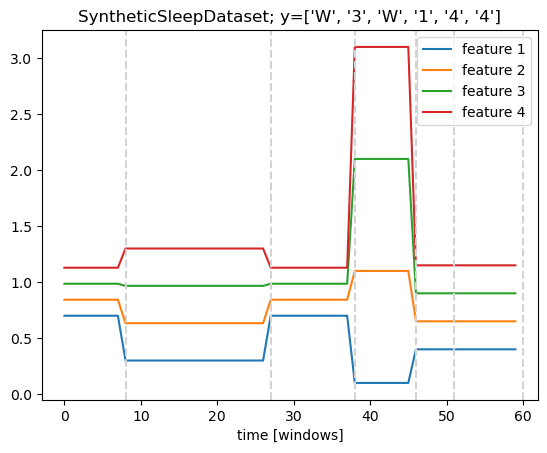

In [419]:
dataset = SyntheticSleepDataset()
#dataset = SleepDataset('sleep')
x, y, stage_lengths = dataset[4]
plt.plot(x[:, 0], label='feature 1')
plt.plot(x[:, 1], label='feature 2')
plt.plot(x[:, 2], label='feature 3')
plt.plot(x[:, 3], label='feature 4')
plt.xlabel('time [windows]')
plt.title(f'{type(dataset).__name__}; y={[dataset.idx_to_sleep_stage[l][-1] for l in y.numpy()]}')
for stage_length in np.cumsum(stage_lengths):
    plt.axvline(x=stage_length, color='lightgrey', linestyle='--')
plt.legend(loc='upper right')
plt.show()

In [420]:

train_set_pct = 0.8
train, validation = torch.utils.data.random_split(dataset, [int(len(dataset)*train_set_pct), len(dataset) - int(len(dataset)*train_set_pct)])

In [438]:
# collate with padded sequences
def collate_fn(batch):
    X, y, stage_lengths = zip(*batch)

    X = torch.concatenate([x.unsqueeze(0) for x in X])
    
    y = rnn.pack_sequence(y, enforce_sorted=False)
    y, y_lens = rnn.pad_packed_sequence(y, batch_first=True, padding_value=100)
    
    # sort both y and X according to y lens
    y_lens, sort_idx = y_lens.sort(descending=True)

    # sort stage_lengths according to sort_idx
    stage_lengths = [stage_lengths[i] for i in sort_idx]

    return X[sort_idx], y[sort_idx], y_lens, stage_lengths

batch_size=32
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
X, y, y_lens, stage_lengths = next(iter(train_loader))

print(X.shape, y.shape, y_lens.shape, len(stage_lengths))

torch.Size([32, 60, 4]) torch.Size([32, 7]) torch.Size([32]) 32


In [453]:
class CTCNetwork(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=num_classes, num_layers=1, 
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(2*num_classes, num_classes)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        out = self.output(x.data)
        out = self.softmax(out)
        return out
    
model = CTCNetwork(num_features=X.shape[-1], num_classes=dataset.num_classes)
emissions = model(X)
print(emissions.shape)
    

torch.Size([32, 60, 9])


In [454]:
y.shape

torch.Size([32, 7])

In [455]:
from tqdm import tqdm
epochs = 100
model = CTCNetwork(num_features=X.shape[-1], num_classes=dataset.num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=10**(-4), momentum=0.9)
model.train()
ctc_loss = nn.CTCLoss()
losses = []
num_steps = len(train_loader)*epochs
epoch = 1
with tqdm(range(num_steps)) as pbar:
    for step in pbar:
        X, y, y_lens, stage_lengths = next(iter(train_loader))
        optimizer.zero_grad()
        emissions = model(X)
        input_lengths = torch.full(size=(X.shape[0],), fill_value=X.shape[1], dtype=torch.long)
        loss = ctc_loss(emissions.permute(1, 0, 2), y, input_lengths, y_lens)
        loss.backward()
        optimizer.step()

        # Report
        if step % 20 ==0 :
            loss = loss.detach().cpu()
            pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

        if (step+1) % len(train_loader) == 0:
            epoch += 1
            losses.append(loss.item())

epoch=100, step=2480, loss=2.4: 100%|██████████| 2500/2500 [00:22<00:00, 113.52it/s]


Text(0, 0.5, 'CTC loss')

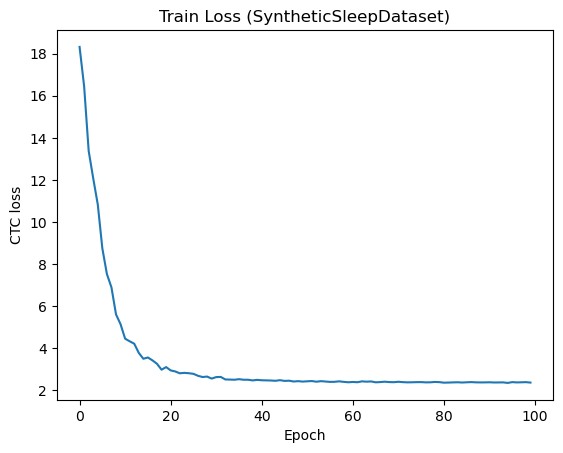

In [456]:
plt.plot(losses)
plt.title(f"Train Loss ({type(dataset).__name__})")
plt.xlabel("Epoch")
plt.ylabel("CTC loss")

In [458]:
y

tensor([[  3,   6,   6,   2,   2,   2,   5],
        [  5,   2,   2,   4,   6,   3,   6],
        [  1,   7,   7,   4,   2,   7, 100],
        [  3,   3,   7,   2,   5,   6, 100],
        [  5,   7,   5,   5,   7,   6, 100],
        [  2,   3,   4,   3,   3,   4, 100],
        [  3,   6,   5,   6,   4,   6, 100],
        [  7,   3,   3,   1,   2,   1, 100],
        [  1,   4,   7,   2,   5,   4, 100],
        [  3,   4,   7,   7,   4,   3, 100],
        [  1,   6,   2,   4,   6,   1, 100],
        [  1,   4,   6,   1,   1,   5, 100],
        [  5,   3,   7,   7,   3,   7, 100],
        [  1,   2,   4,   5,   5,   2, 100],
        [  6,   5,   3,   5,   3,   6, 100],
        [  7,   7,   3,   6,   2,   6, 100],
        [  2,   3,   1,   6,   1, 100, 100],
        [  3,   4,   1,   7,   4, 100, 100],
        [  2,   5,   6,   7,   6, 100, 100],
        [  1,   4,   2,   1,   1, 100, 100],
        [  3,   6,   1,   3,   5, 100, 100],
        [  7,   6,   1,   5,   2, 100, 100],
        [ 

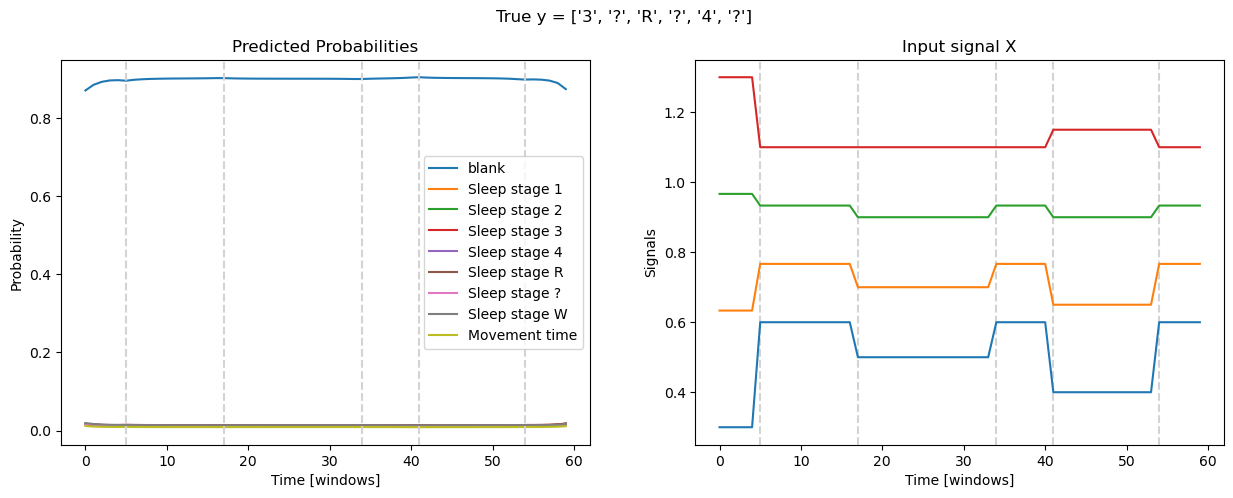

In [457]:
import matplotlib.pyplot as plt
val_loader = torch.utils.data.DataLoader(validation, batch_size=32, shuffle=True, collate_fn=collate_fn)
X, y, y_lens, stage_lengths = next(iter(val_loader))

model.eval()
emissions = model(X)

id = 6

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

probs = np.exp(emissions[id].detach().numpy())
for i in range(probs.shape[1]):
    times = np.arange(probs.shape[0])
    axs[0].plot(times, probs[:, i], label=dataset.idx_to_sleep_stage[i] if i != 0 else 'blank')
preds = [dataset.idx_to_sleep_stage[l][-1] for l in y[id][:y_lens[id]].numpy()]
fig.suptitle(f'True y = {preds}')
axs[0].set_title('Predicted Probabilities')
axs[0].set_ylabel('Probability')
axs[0].set_xlabel('Time [windows]')
for stage_length in np.cumsum(stage_lengths[id])[:-1]:
    axs[0].axvline(x=stage_length, color='lightgrey', linestyle='--')
    axs[1].axvline(x=stage_length, color='lightgrey', linestyle='--')
axs[0].legend()
axs[1].plot(X[id].numpy())
axs[1].set_title('Input signal X')
axs[1].set_ylabel('Signals')
axs[1].set_xlabel('Time [windows]')
plt.show()